# Encoder-Decoder Models

By: Dr. Jie Tao

Ver: 0.1

[OP](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

The encoder-decoder model provides a pattern for using recurrent neural networks to address challenging sequence-to-sequence prediction problems such as machine translation.

Encoder-decoder models can be developed in the Keras Python deep learning library and an example of a neural machine translation system developed with this model has been described on the Keras blog, with sample code distributed with the Keras project.

This example can provide the basis for developing encoder-decoder LSTM models for your own sequence-to-sequence prediction problems.

In this tutorial, you will discover how to develop a sophisticated encoder-decoder recurrent neural network for sequence-to-sequence prediction problems with Keras.

After completing this tutorial, you will know:

- How to correctly define a sophisticated encoder-decoder model in Keras for sequence-to-sequence prediction.
- How to define a contrived yet scalable sequence-to-sequence prediction problem that you can use to evaluate the encoder-decoder LSTM model.
- How to apply the encoder-decoder LSTM model in Keras to address the scalable integer sequence-to-sequence prediction problem.

__NOTE__: Autoencoder is a special type of encoder-decoder model; when encoder and decoder are mirrored so the input and output are supposed to be identical. Sequence-to-sequence models, or encoder-decoder models, doesn't require the input and output to be identical, so the model artchitecures are not identical.


## What is sequence-to-sequence learning?
Sequence-to-sequence learning (`Seq2Seq`) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to French).

```python
"the cat sat on the mat" -> [Seq2Seq model] -> "le chat etait assis sur le tapis"
```
This can be used for machine translation or for free-from question answering (generating a natural language answer given a natural language question) -- in general, it is applicable any time you need to generate text.

There are multiple ways to handle this task, either using `RNN`s or using `1D convnet`s. Here we will focus on `RNN`s.

## The trivial case: when input and output sequences have the same length
When both input sequences and output sequences have the same length, you can implement such models simply with a `Keras LSTM` or `GRU` layer (or stack thereof). For example:

<img src = "https://blog.keras.io/img/seq2seq/addition-rnn.png" />

One caveat of this approach is that it assumes that it is possible to generate `target[...t]` given `input[...t]`. That works in some cases (e.g. adding strings of digits) but does not work for most use cases. In the general case, information about the entire input sequence is necessary in order to start generating the target sequence.

## The general case: canonical sequence-to-sequence
In the general case, input sequences and output sequences have __different__ lengths (e.g. machine translation) and the entire input sequence is required in order to start predicting the target. This requires a more advanced setup, which is what people commonly refer to when mentioning "sequence to sequence models" with no further context. Here's how it works:

- A `RNN` layer (or stack thereof) acts as "encoder": it processes the input sequence and returns its own __internal state__. Note that we *discard* the outputs of the encoder RNN, only recovering the state. This state will serve as the "context", or "conditioning", of the decoder in the next step.
- Another `RNN` layer (or stack thereof) acts as "decoder": it is trained to predict the next characters of the target sequence, given previous characters (context) of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but **offset by one timestep** in the future, a training process called **teacher forcing** in this context. Importantly, the encoder uses as **initial state** the state vectors from the encoder (as input), which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate `targets[t+1...]` given `targets[...t]`, conditioned on the input sequence.

<img src = "https://blog.keras.io/img/seq2seq/seq2seq-teacher-forcing.png" />


In inference mode, i.e. when we want to decode unknown input sequences, we go through a slightly different process:

1. Encode the input sequence into state vectors.
2. Start with a target sequence of size 1 (just the start-of-sequence character).
3. Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character.
4. Sample the next character using these predictions (we simply use `argmax`).
5. Append the sampled character to the target sequence
6. Repeat until we generate the end-of-sequence character or we hit the character limit.

<img src = "https://blog.keras.io/img/seq2seq/seq2seq-inference.png" />

## Encoder-Decoder Model in Keras
The encoder-decoder model is a way of organizing recurrent neural networks for sequence-to-sequence prediction problems.

It was originally developed for machine translation problems, although it has proven successful at related sequence-to-sequence prediction problems such as text summarization and question answering.

The approach involves two recurrent neural networks, one to encode the source sequence, called the encoder, and a second to decode the encoded source sequence into the target sequence, called the decoder.

In [ ]:
# from random import randint
import numpy as np
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

We can define a function for the model.

In [ ]:
n_input = 51
n_output = 51
n_units = 128

In [ ]:
# define training encoder
encoder_inputs = Input(shape=(None, n_input))
encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(None, n_output))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(n_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

Let's plot the overall architecture of the encoder-decoder model.

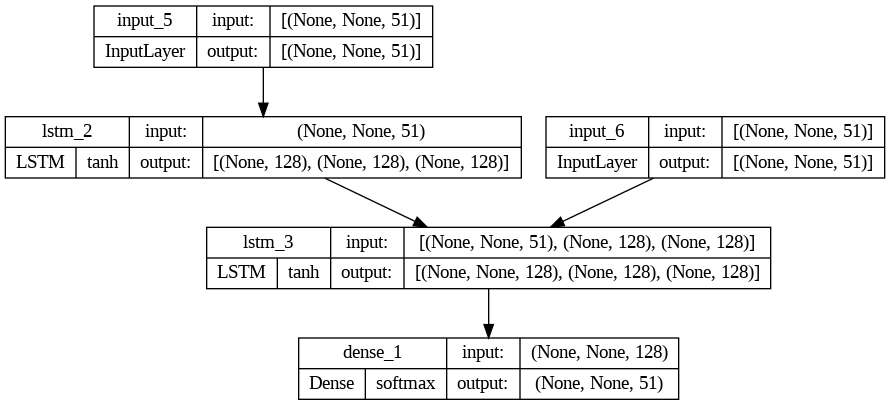

In [ ]:
plot_model(model, show_layer_activations=True, show_shapes=True)

#### Answer the Question:

Can you tell what `input_2` is?

Let's take a look at the __inference__ `encoder` and `decoder` model separately (we use them to make predictions).

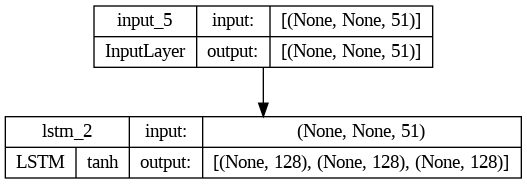

In [ ]:
plot_model(encoder_model, show_layer_activations=True, show_shapes=True)

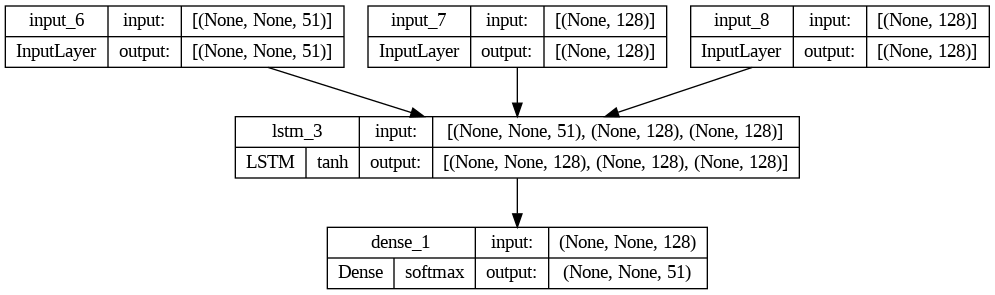

In [ ]:
plot_model(decoder_model, show_layer_activations=True, show_shapes=True)

### How encoder-decoder work?

If we try to use the sequence `[1,2,3]` to predict the target sequence `[4,5,6]`. The inputs and outputs to the model during training would be:

```python
Input1: ['1', '2', '3']
Input2: ['_', '4', '5']
Output: ['4', '5', '6']
```

The model is intended to be called recursively when generating target sequences for new source sequences.

The source sequence is encoded and the target sequence is generated one element at a time, using a “start of sequence” character such as `_` to start the process. Therefore, in the above case, the following input-output pairs would occur during training:

```python
step,  Input1,		  Input2,	 Output
   1,  ['1', '2', '3'],	'_',		'4'
   2,  ['1', '2', '3'],	'4',		'5'
   3,  ['1', '2', '3'],	'5',		'6'
```

Here you can see how the recursive use of the model can be used to build up output sequences.

During prediction, the inference_encoder model is used to encode the input sequence once which returns states that are used to initialize the inference_decoder model. From that point, the inference_decoder model is used to generate predictions step by step.

The function below named `predict_sequence()` can be used after the model is trained to generate a target sequence given a source sequence.

In [ ]:
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
  """
  generate target given source sequence
  ARGs:
  - infenc: Inference encoder model used when making a prediction for a new source sequence.
  - infdec: Inference decoder model use when making a prediction for a new source sequence.
  - source: Encoded source sequence.
  - n_steps: Number of time steps in the target sequence.
  - cardinality: The cardinality of the output sequence,
  e.g. the number of features, words, or characters for each time step.
  """
  # encode
  state = infenc.predict(source)
	# start of sequence input
  target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
	# collect predictions
  output = list()
  for t in range(n_steps):
    # predict next char
    yhat, h, c = infdec.predict([target_seq] + state, verbose=0)
    # store prediction
    output.append(yhat[0,0,:])
		# update state
    state = [h, c]
		# update target sequence
    target_seq = yhat
  return np.array(output)

In order to make sure the model works, let's generate some training and testing data. In this case, both sets contains series of randomly generated integer values, such as `[20, 36, 40, 10, 34, 28]`, and the target sequence is a reversed pre-defined subset of the input sequence, such as the first 3 elements in reverse order `[40, 36, 20]`.

The length of the source sequence is configurable; so is the cardinality of the input and output sequence and the length of the target sequence. For example:

```python
Source,						Target
[13, 28, 18, 7, 9, 5]		[18, 28, 13]
[29, 44, 38, 15, 26, 22]	[38, 44, 29]
[27, 40, 31, 29, 32, 1]		[31, 40, 27]
...
```

Let’s start off by defining a function to generate a sequence of random integers.

We will use the value of `0` as the padding or start of sequence character, therefore it is reserved and we cannot use it in our source sequences. To achieve this, we will add 1 to our configured cardinality to ensure the one-hot encoding is large enough (e.g. a value of `1` maps to a `1` value in index 1).

In [ ]:
# generate a sequence of random integers
import random
def generate_sequence(length, n_unique):
	return [random.randint(1, n_unique-1) for _ in range(length)]

Next, we need to create the corresponding output sequence given the source sequence.

To keep thing simple, we will select the first n elements of the source sequence as the target sequence and reverse them.

```python
# define target sequence
target = source[:n_out]
target.reverse()
```

We also need a version of the output sequence shifted forward by one time step that we can use as the mock target generated so far, including the start of sequence value in the first time step. We can create this from the target sequence directly.

```python
# create padded input target sequence
target_in = [0] + target[:-1]
```

Put things together, we can use the function below to generate the sequences we needed.

In [ ]:
# prepare data for the LSTM
def get_dataset(n_input, n_output, cardinality, n_samples):
  X1, X2, y = list(), list(), list()
  for _ in range(n_samples):
   # generate source sequence
   source = generate_sequence(n_input, cardinality)
   #print(source)
   # define target sequence
   target = source[:n_output]#[::-1]
   target.reverse()
   #print(target)
   # create padded input target sequence
   target_in = [0] + target[:-1]
   #print(target_in)
   # encode
   src_encoded = to_categorical(source, num_classes=cardinality)
   tar_encoded = to_categorical(target, num_classes=cardinality)
   tar2_encoded = to_categorical(target_in, num_classes=cardinality)
   # store
   X1.append(src_encoded) ### input 1: original sequences
   X2.append(tar2_encoded) ### input 2: 1 number shifted sequences
   y.append(tar_encoded) ### target
  return np.array(X1), np.array(X2), np.array(y)

inally, we need to be able to make the predicted sequences readable: the predicted are probabilities, we need to make them integers.

This is needed for both printing the generated target sequences but also for easily comparing whether the full predicted target sequence matches the expected target sequence. The `one_hot_decode()` function will decode an encoded sequence.

In [ ]:
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [np.argmax(vector) for vector in encoded_seq]

Now we can show case the data generation functions.

In [ ]:
# configure problem
n_features = 50 + 1
n_steps_in = 6 # input contains 6 integers
n_steps_out = 3 # output contains 3

# generate a single source and target sequence
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
print(X1.shape, X2.shape, y.shape)
print('X1=%s, X2=%s, y=%s' % (one_hot_decode(X1[0]), one_hot_decode(X2[0]), one_hot_decode(y[0])))

(1, 6, 51) (1, 3, 51) (1, 3, 51)
X1=[38, 44, 5, 35, 32, 44], X2=[0, 5, 44], y=[5, 44, 38]


Now we can use the model we defined above.

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

We can use the above utility functions to generate some actual data.

In [ ]:
# generate training dataset
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
print(X1.shape,X2.shape,y.shape)

(100000, 6, 51) (100000, 3, 51) (100000, 3, 51)


And then use above data to start training.

In [ ]:
from keras.callbacks import EarlyStopping
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience = 1, verbose=1)
# train model
model.fit([X1, X2], y, epochs=40, batch_size=1000, validation_split=0.2, callbacks=[es])

Epoch 1/40
80/80 [==============================] - 19s 196ms/step - loss: 3.9012 - accuracy: 0.0486 - val_loss: 3.8527 - val_accuracy: 0.1248
Epoch 2/40
80/80 [==============================] - 15s 185ms/step - loss: 3.3708 - accuracy: 0.1944 - val_loss: 2.6361 - val_accuracy: 0.2720
Epoch 3/40
80/80 [==============================] - 16s 205ms/step - loss: 2.2765 - accuracy: 0.3179 - val_loss: 2.0345 - val_accuracy: 0.3485
Epoch 4/40
80/80 [==============================] - 15s 184ms/step - loss: 1.8827 - accuracy: 0.3692 - val_loss: 1.7546 - val_accuracy: 0.3844
Epoch 5/40
80/80 [==============================] - 15s 183ms/step - loss: 1.6599 - accuracy: 0.4026 - val_loss: 1.5609 - val_accuracy: 0.4208
Epoch 6/40
80/80 [==============================] - 15s 184ms/step - loss: 1.4843 - accuracy: 0.4410 - val_loss: 1.3839 - val_accuracy: 0.4618
Epoch 7/40
80/80 [==============================] - 15s 184ms/step - loss: 1.3203 - accuracy: 0.4878 - val_loss: 1.2439 - val_accuracy: 0.5140

Once the model is trained, we can evaluate it. We will do this by making predictions for `100` source sequences and counting the number of target sequences that were predicted correctly. We will use the numpy `array_equal()` function on the decoded sequences to check for equality.

In [ ]:
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(encoder_model, decoder_model, X1, n_steps_out, n_features)
	if np.array_equal(one_hot_decode(y[0]), one_hot_decode(target)):
		correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

1/1 [==============================] - 0s 23ms/step
Accuracy: 100.00%


Let's look at some data to see how the model performs.

In [ ]:
for _ in range(10):
 X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
 target = predict_sequence(encoder_model, decoder_model, X1, n_steps_out, n_features)
 print('X={}, y={}, yhat={}'.format(one_hot_decode(X1[0]), one_hot_decode(y[0]), one_hot_decode(target)))

1/1 [==============================] - 0s 23ms/step
X=[50, 50, 42, 30, 34, 33], y=[42, 50, 50], yhat=[42, 50, 50]
1/1 [==============================] - 0s 25ms/step
X=[25, 45, 27, 10, 30, 6], y=[27, 45, 25], yhat=[27, 45, 25]
1/1 [==============================] - 0s 23ms/step
X=[31, 2, 26, 22, 28, 19], y=[26, 2, 31], yhat=[26, 2, 31]
1/1 [==============================] - 0s 23ms/step
X=[47, 39, 37, 47, 13, 2], y=[37, 39, 47], yhat=[37, 39, 47]
1/1 [==============================] - 0s 22ms/step
X=[23, 44, 23, 40, 44, 10], y=[23, 44, 23], yhat=[23, 44, 23]
1/1 [==============================] - 0s 23ms/step
X=[45, 30, 27, 16, 12, 14], y=[27, 30, 45], yhat=[27, 30, 45]
1/1 [==============================] - 0s 26ms/step
X=[10, 8, 45, 27, 12, 50], y=[45, 8, 10], yhat=[45, 8, 10]
1/1 [==============================] - 0s 23ms/step
X=[23, 3, 22, 49, 10, 27], y=[22, 3, 23], yhat=[22, 3, 23]
1/1 [==============================] - 0s 22ms/step
X=[20, 34, 49, 25, 35, 48], y=[49, 34, 20], yha